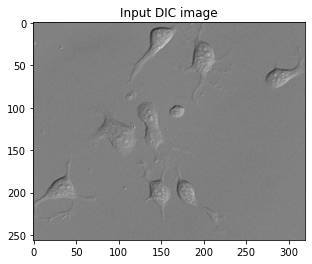

In [1]:
import numpy as np, scipy, skimage, time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy import ndimage
import imageio
import matplotlib.pyplot as plt

#read image
g = np.double(imageio.imread("DICImage.tif"))
nrows, ncols = g.shape
N = nrows*ncols

xx, yy = np.meshgrid(np.arange(1, ncols+1), np.arange(1, nrows+1))
xx = xx.flatten(); yy = yy.flatten()
X = np.column_stack((np.ones(N), xx, yy, xx**2, xx*yy, yy**2))
p = np.linalg.lstsq(X, g.flatten(), rcond=None)[0]
g = np.reshape(g.flatten()-np.dot(X, p), (nrows,ncols))
g = g/np.max(np.abs(g)) #image value in [-1,1]
plt.imshow(g,cmap='gray', vmin=-1, vmax=1); plt.title('Input DIC image'); plt.show()


In [2]:
#compute the H (imaging model), L (smooth) matrices
tt = time.process_time() #use time instead of cputime
#get the differential kernel for H
sigma = 1 #sigma in the first-derivative-of-Gaussian kernel
theta = 225*np.pi/180+np.pi #this parameter is related to this given image's microscope parameter
radius = max(2*np.ceil(sigma),1).astype(int)
diameter = 2*radius + 1
xx,yy = np.meshgrid(np.arange(-radius,radius+1),np.arange(-radius,radius+1))
tmp = np.exp(-0.5*(xx**2 + yy**2)/sigma**2)
h_kernel = -(np.cos(theta)*xx+np.sin(theta)*yy)*tmp
h_kernel = h_kernel/np.sum(np.abs(h_kernel))

#build the sparse H matrix
nzidx = np.abs(h_kernel.flatten()) > 0.001 #save memory and speed up by ignoring small elements
inds = np.arange(1, N+1).reshape(nrows, ncols)
inds_pad = np.pad(inds, ((radius, radius), (radius, radius)), mode='symmetric') #deal with the boundary
row_inds = np.repeat(np.arange(1, N+1), np.sum(nzidx))
col_inds = np.ravel(np.array([inds_pad[i:i+diameter, j:j+diameter] for i in range(nrows) for j in range(ncols)])) #slide col and then row
col_inds = col_inds[np.tile(nzidx, N)]
vals = np.tile(h_kernel.flatten()[nzidx], N)
H = sp.csr_matrix((vals, (row_inds-1, col_inds-1)), shape=(N, N))


#get the smooth kernel for L
hwid = 1; wid = 2*hwid + 1; nsz = wid**2
D = -np.ones((wid,wid))/(nsz-1)
D[hwid,hwid] = 1


# build the sparse L matrix
inds = np.reshape(np.arange(1, N + 1), (nrows, ncols))
inds_pad = np.pad(inds, ((hwid, hwid), (hwid, hwid)), mode='symmetric')
row_inds = np.tile(np.arange(1, N + 1), (nsz, 1))
col_inds = skimage.util.view_as_windows(inds_pad, (wid, wid), step=1).reshape(-1, wid**2).T
vals = np.tile(D.ravel(), (N, 1)).T
L = scipy.sparse.coo_matrix((vals.ravel(), (row_inds.ravel() - 1, col_inds.ravel() - 1)), shape=(N, N)).tocsr()
print(f'get H and L: {time.process_time() - tt:.3f} seconds')




get H and L: 0.311 seconds


# Your implementation below:

In [3]:
# Need to implement gamma, tol, maxiter, w_sparsity, w_smooth

In [4]:
# Assigning values to the elements that we will need in the algorithm
gamma = 0.35
tol = 0.09
maxiter = 300
w_sparsity = 1
w_smooth = 0.3

In [5]:
Q = H.transpose().dot(H) + w_smooth*L
Qp = sp.csr_matrix.maximum(Q,0)
Qn = sp.csr_matrix.minimum(Q,0)
f = np.ones((N,1))
#Lambda = sp.csr_matrix(np.ones((N,1)))
Lambda = np.ones((N,1))
print(g.shape)
g = g.reshape(-1,1)
print(g.shape)
print(Lambda.shape)
print(H.shape)
print(Qp.shape)
print(f.shape)

(256, 320)
(81920, 1)
(81920, 1)
(81920, 81920)
(81920, 81920)
(81920, 1)


In [7]:
# Implementing the algorithm mentioned
f = np.zeros(N) # Initialize to 0 values into Nx1 array.
Lambda = np.zeros(N) # Just the diagonal values such that Nx1 array.

# Initialize the Q array such that (H^T)H + (omega_s)L.
# (L^T)L here because it works out better in terms of computing it.
Q = H.transpose().dot(H) + w_smooth*L.T.dot(L)
Q_plus = sp.csr_matrix.maximum(Q, 0)
Q_minus = sp.csr_matrix.minimum(Q, 0)

# defining the b value, but didn't add negative sign since it ruined output.
b = H.transpose().dot(g.flatten())

# The main for loop for this algorithm.
for k in range(maxiter):
    f_old = f.copy()
    Lambda_old = Lambda.copy()
    f = spla.cg(Q, b + gamma*L.T.dot(Lambda), x0=f, tol=tol)[0]
    Lambda = np.maximum(0, np.abs(f + gamma*L.dot(Lambda)) - w_sparsity/gamma)*np.sign(f + gamma*L.dot(Lambda))
    Lambda = spla.cg(L.T.dot(L), L.T.dot(Lambda), tol=tol)[0]
    if np.linalg.norm(f - f_old) / np.linalg.norm(f_old) < tol and np.linalg.norm(Lambda - Lambda_old) / np.linalg.norm(Lambda_old) < tol:
        break

/var/folders/b8/_yk1qcfj67q396_kqt7flbv00000gn/T/ipykernel_19218/523985152.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  if np.linalg.norm(f - f_old) / np.linalg.norm(f_old) < tol and np.linalg.norm(Lambda - Lambda_old) / np.linalg.norm(Lambda_old) < tol:
/var/folders/b8/_yk1qcfj67q396_kqt7flbv00000gn/T/ipykernel_19218/523985152.py:21: RuntimeWarning: invalid value encountered in double_scalars
  if np.linalg.norm(f - f_old) / np.linalg.norm(f_old) < tol and np.linalg.norm(Lambda - Lambda_old) / np.linalg.norm(Lambda_old) < tol:


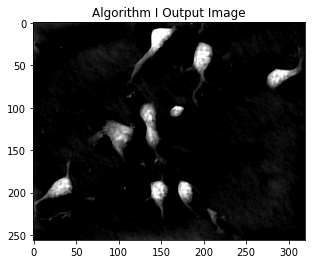

In [8]:
# Displaying the output image to the user.

f = np.reshape(f, (nrows, ncols))
plt.imshow(f, cmap='gray', vmin=0, vmax=1)
plt.title('Algorithm I Output Image')
plt.show()